In [1]:
from PCA import PCA
from sklearn.datasets import make_blobs, make_spd_matrix
from sklearn import preprocessing
import scipy
import jax.numpy as np
import matplotlib.pyplot as plt
from jax import flatten_util, jacrev, random, jvp, vjp, vmap, linearize, jit
from utils import *
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

In [2]:
#n=20
#p=100
#X, y = make_blobs(n_samples=n, n_features=p, centers=4, random_state=2, shuffle=False, cluster_std=5)
#B = 1*make_spd_matrix(p, random_state=27)
#A = 1*make_spd_matrix(n, random_state=27)
#X = scipy.stats.matrix_normal.rvs(mean=X, rowcov=A, colcov=B, size=1, random_state=27) 
#scale_values = np.diag(np.array([i for i in range(1, p+1)]))
##X = X.dot(scale_values)
## center X
#X = X - np.mean(X, axis=0)
#X_flat, X_unflattener = flatten_util.ravel_pytree(X)
#p_keep = 2

In [2]:
def student_grades_data_set():
    Y = np.array([[15, 12.29, 14.1, 15],
                  [9, 15.29, 12.29, 10],
                  [6, 10.5, 16.5, 15.3],
                  [12.29, 17.8, 19, 11],
                  [2.17, 7.71, 12, 14],
                  [1, 5, 9, 7.5]])

    cov_Y = np.array([0.1, 0.1, 0.1, 1.23,
                     1.97, 0.1, 1.23, 1.23,
                     0.08, 1.97, 1.23, 0.33,
                     33.33  , 1.23, 4.08, 0.1,
                     1.33, 0.1, 0.33, 0.1,
                     1.23, 0.33, 0.1, 0.75])
    cov_Y = np.reshape(cov_Y, (Y.shape[0], Y.shape[1]), 'F')
    cov_Y = flatten_util.ravel_pytree(cov_Y)[0]
    y = ['Tom', 'David', 'Bob', 'Jane', 'Joe', 'Jack']
    np.save('data/studentgrades/mean.npy', Y)
    np.save('data/studentgrades/covariance_matrix.npy', cov_Y)
    np.save('data/studentgrades/labels.npy', y)
    return Y, y, cov_Y

/home/zabel/vipurpca/src/utils.py:87: RuntimeWarning: invalid value encountered in true_divide
  M = np.dot(mu, np.expand_dims(np.cos(theta), axis=0)) + E * np.sin(theta) / theta


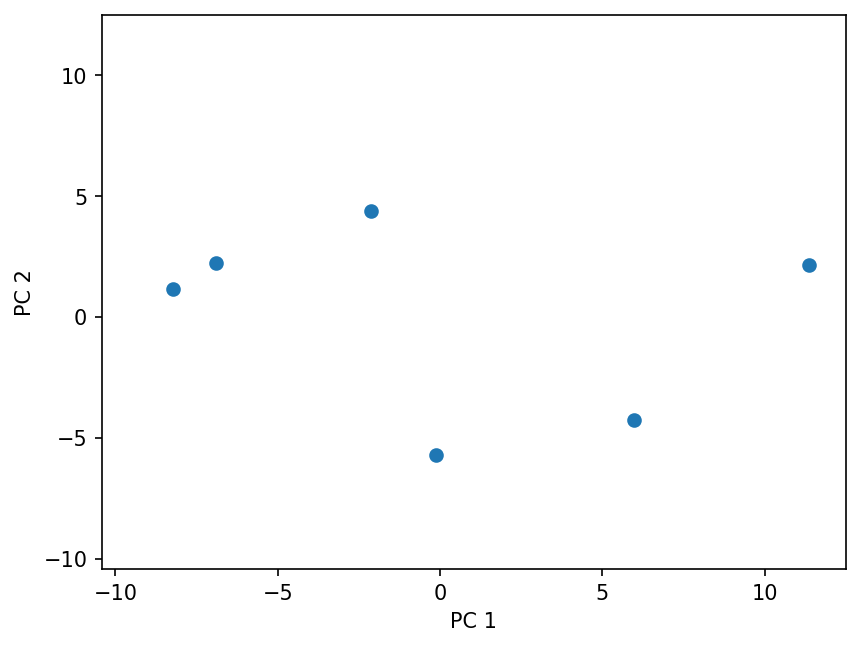

In [3]:
X, y, cov = student_grades_data_set()
pca = PCA(matrix=X, sample_cov=None, feature_cov=None, 
          full_cov=cov, n_components=3, axis=0)
pca.pca_value()
pca.compute_cov_eigenvectors(save_jacobian=True)
pca.animate(1, 2, labels=None)

In [4]:
pca.eigenvalues

DeviceArray([46.967907 ,  8.986444 ,  5.8201885], dtype=float32)

In [16]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
def load_estrogen_dataset():
    Y_df = pd.read_csv('data_old/estrogen/mean.csv')

    sde = pd.read_csv('data_old/estrogen/standard_error.csv')

    Y = np.transpose(Y_df.values)

    # consider only upper 10% variant genes
    v = []
    for i in range(Y.shape[1]):
        v.append(np.var(Y[:, i]))
    selector = VarianceThreshold(np.quantile(v, 0.9))
    Y = selector.fit_transform(Y)

    sde = selector.transform(np.transpose(sde.values))

    # standard error to variance
    cov_Y = (np.diag(sde.flatten('F')) * np.sqrt(12)) ** 2

    labels = list(Y_df.columns)
    return Y, cov_Y, labels

In [17]:
X, C, y = load_estrogen_dataset()

In [23]:
C_correct = np.reshape(np.diagonal(C), (X.shape[0], X.shape[1]), 'F')
C_correct = flatten_util.ravel_pytree(C_correct)[0]

/home/zabel/vipurpca/src/utils.py:87: RuntimeWarning: invalid value encountered in true_divide
  M = np.dot(mu, np.expand_dims(np.cos(theta), axis=0)) + E * np.sin(theta) / theta


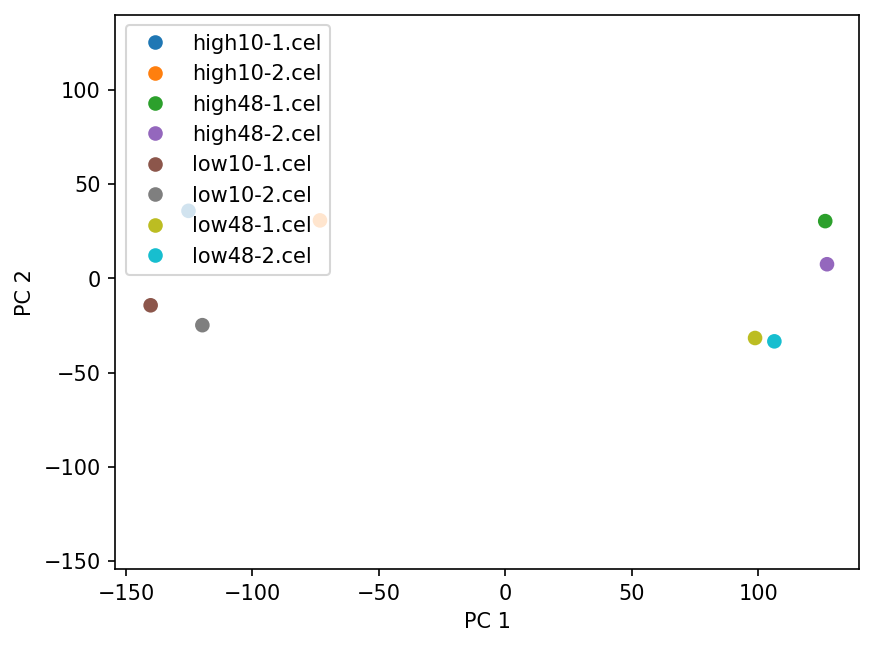

In [28]:
pca = PCA(matrix=X, sample_cov=None, feature_cov=None, 
          full_cov=C_correct, n_components=2, axis=0)
pca.pca_value()
pca.compute_cov_eigenvectors(save_jacobian=False)
pca.animate(1, 2, labels=y)

In [29]:
np.save('data/estrogen/mean.npy', X)
np.save('data/estrogen/covariance_matrix.npy', C_correct)
np.save('data/estrogen/labels.npy', y)

In [30]:
def load_mice_dataset():
    data = np.load('data_old/mice/mice_data.npy')
    y = np.load('data_old/mice/labels.npy')
    cov_Y = np.cov(data)
    mean = np.mean(data, axis=1)
    Y = np.transpose(mean.reshape((77, 73)))
    return Y, cov_Y, y

In [31]:
X, C, y = load_mice_dataset()

In [45]:
C_correct = vmap(lambda x: flatten_util.ravel_pytree(np.reshape(x, (X.shape[0], X.shape[1]), 'F'))[0])(C)
#C_correct = flatten_util.ravel_pytree(C_correct)[0]

In [46]:
C_correct = vmap(lambda x: flatten_util.ravel_pytree(np.reshape(x, (X.shape[0], X.shape[1]), 'F'))[0])(C_correct.T)

In [50]:
print(X.shape)

(73, 77)


In [51]:
print(C.shape)

(5621, 5621)


In [61]:
print(C[0, 1])

0.0007661665395357799


In [67]:
print(C_correct[0, 77])

0.00076616654


/home/zabel/vipurpca/src/utils.py:87: RuntimeWarning: invalid value encountered in true_divide
  M = np.dot(mu, np.expand_dims(np.cos(theta), axis=0)) + E * np.sin(theta) / theta


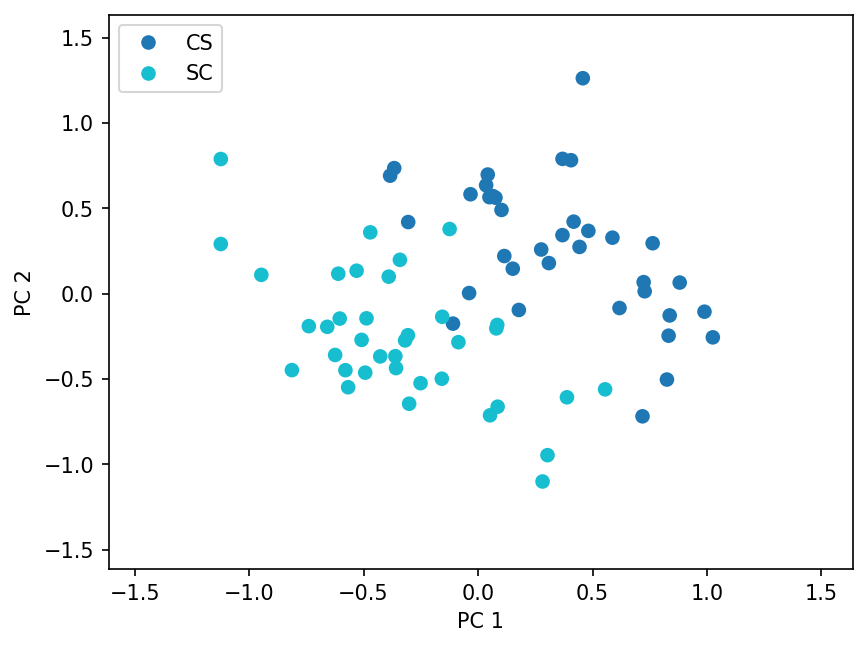

In [58]:
pca = PCA(matrix=X, sample_cov=None, feature_cov=None, 
          full_cov=C_correct, n_components=2, axis=0)
pca.pca_value()
pca.compute_cov_eigenvectors(save_jacobian=False)
pca.animate(1, 2, labels=y)

In [68]:
np.save('data/mice/mean.npy', X)
np.save('data/mice/covariance_matrix.npy', C_correct)
np.save('data/mice/labels.npy', y)